In [1]:
import numpy as np
import pandas as pd
from sklearn import compose, model_selection, preprocessing, metrics, neighbors,linear_model, svm, tree, naive_bayes, neighbors, neural_network, ensemble
from catboost import CatBoostClassifier

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
train_df = pd.read_csv('../data/train_preprocessed.csv')
test_df = pd.read_csv('../data/test_preprocessed.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
import matplotlib.pyplot as plt
import yellowbrick as yb

def evaluate(estimator, param_grid):
    print('Given parameters: ', param_grid)
    grid_search = HalvingGridSearchCV(estimator, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('Best params: ', grid_search.best_params_)
    print('Accuracy: ', grid_search.best_score_)
    best = grid_search.best_estimator_
    predict = best.predict(X_test)
    print(metrics.confusion_matrix(y_test, predict))
    print(metrics.classification_report(y_test, predict))
    visualizer = yb.ROCAUC(best,binary=True, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    return grid_search

In [4]:
X = train_df.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket'])
y = train_df['Survived']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
y_train = y_train.ravel()

In [5]:
scaler = preprocessing.StandardScaler()
column_transformer = compose.make_column_transformer(
    (scaler, ['Age', 'Fare', 'Cabin number']),
    remainder='passthrough')
X_train = column_transformer.fit_transform(X_train, y_train)
X_test = column_transformer.transform(X_test)

Decision Tree Classifier:

Given parameters:  {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, None], 'min_samples_split': [2, 3, 4, 5, 7, 10, 15, 20, 10000]}
Best params:  {'max_depth': 4, 'min_samples_split': 5}
Accuracy:  0.7727327327327327
[[10809  3495]
 [ 2331  8365]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     14304
           1       0.71      0.78      0.74     10696

    accuracy                           0.77     25000
   macro avg       0.76      0.77      0.76     25000
weighted avg       0.77      0.77      0.77     25000



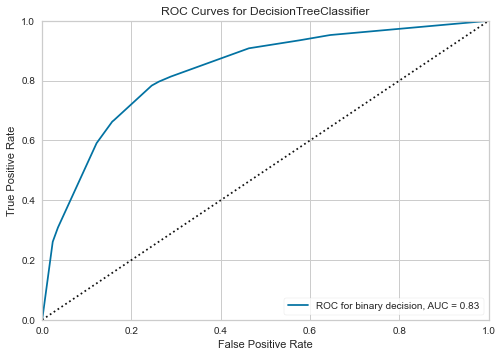

Wall time: 4.6 s


In [6]:
%%time
tree_estimator = tree.DecisionTreeClassifier()
tree_param_grid = dict(max_depth=[3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, None], min_samples_split=[2, 3, 4, 5, 7, 10, 15, 20, 10000])
print('Decision Tree Classifier:\n')
tree_optimal = evaluate(tree_estimator, tree_param_grid)

In [7]:
tree_optimal.fit(X, y)
tree_predict = tree_optimal.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

In [8]:
submission['Survived'] = tree_predict
submission.to_csv('../data/submission_tree.csv', index=False)

In [9]:
from yellowbrick.contrib.wrapper import wrap

catboost_estimator = wrap(CatBoostClassifier())

In [10]:
%%time
catboost_estimator.fit(X_train, y_train, verbose=0)

Wall time: 20.1 s


accuracy: 0.77564
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     14304
           1       0.74      0.72      0.73     10696

    accuracy                           0.78     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.78      0.78      0.78     25000

[[11646  2658]
 [ 2951  7745]]


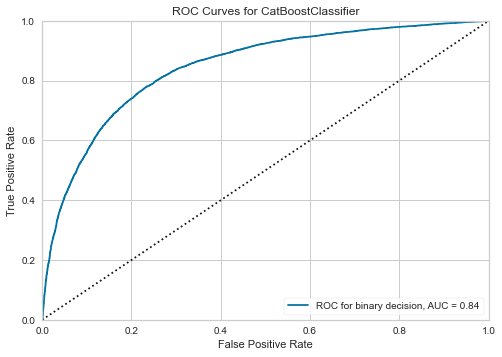

In [11]:
catboost_predict = catboost_estimator.predict(X_test)
print("accuracy:", metrics.accuracy_score(y_test, catboost_predict))
print(metrics.classification_report(y_test, catboost_predict))
print(metrics.confusion_matrix(y_test, catboost_predict))
visualizer = yb.ROCAUC(catboost_estimator, binary=True, classes=[0, 1])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [12]:
catboost_estimator.fit(X, y, verbose=0)
catboost_predict = catboost_estimator.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

In [13]:
submission['Survived'] = catboost_predict
submission.to_csv('../data/submission_catboost.csv', index=False)

Given parameters:  {'min_samples_split': [10, 50, 100, 150, 1000, 10000]}
Best params:  {'min_samples_split': 150}
Accuracy:  0.7794133333333334
[[11638  2666]
 [ 2929  7767]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     14304
           1       0.74      0.73      0.74     10696

    accuracy                           0.78     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.78      0.78      0.78     25000



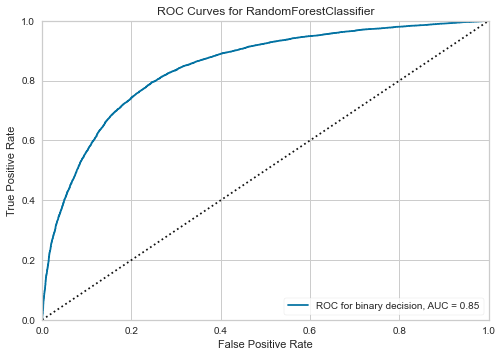

Wall time: 14.8 s


In [14]:
%%time
forest_estimator = ensemble.RandomForestClassifier(bootstrap=True, n_estimators=100, n_jobs=-1)
forest_param_grid = dict(min_samples_split=[10, 50, 100, 150, 1000, 10000])
best_forest = evaluate(forest_estimator, forest_param_grid)

In [15]:
best_forest.fit(X, y)
forest_predict = best_forest.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

In [16]:
submission['Survived'] = forest_predict
submission.to_csv('../data/submission_forest.csv', index=False)

Given parameters:  {'max_depth': [None], 'min_samples_split': [2, 5, 10, 100, 1000, 10000]}
Best params:  {'max_depth': None, 'min_samples_split': 100}
Accuracy:  0.7797333333333334
[[11613  2691]
 [ 2920  7776]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     14304
           1       0.74      0.73      0.73     10696

    accuracy                           0.78     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.78      0.78      0.78     25000



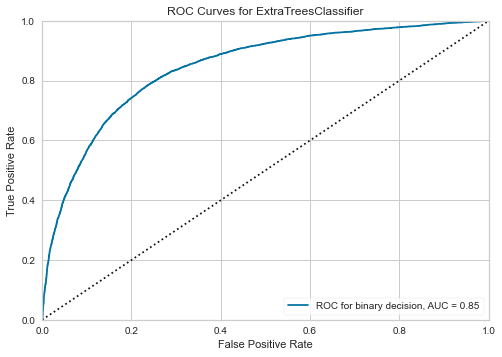

Wall time: 12.6 s


In [17]:
%%time
et_estimator = ensemble.ExtraTreesClassifier(n_jobs=-1, bootstrap=True)
et_param_grid = dict(max_depth=[None], min_samples_split=[2, 5, 10, 100, 1000, 10000])
best_et = evaluate(et_estimator, et_param_grid)

In [18]:
best_et.fit(X, y)
et_predict = best_et.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

In [19]:
submission['Survived'] = et_predict
submission.to_csv('../data/submission_et.csv', index=False)

In [28]:
stacking = ensemble.StackingClassifier([('tree', tree_optimal), ('extra trees', best_et), ('catboost', CatBoostClassifier()), ('forest', best_forest)], n_jobs=4)

In [29]:
%%time
stacking.fit(X_train, y_train)

Wall time: 4min 38s


StackingClassifier(estimators=[('tree',
                                HalvingGridSearchCV(estimator=DecisionTreeClassifier(),
                                                    n_jobs=-1,
                                                    param_grid={'max_depth': [3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10,
                                                                              15,
                                                                              

accuracy: 0.77728
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     14304
           1       0.75      0.72      0.73     10696

    accuracy                           0.78     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.78      0.78      0.78     25000

[[11714  2590]
 [ 2978  7718]]


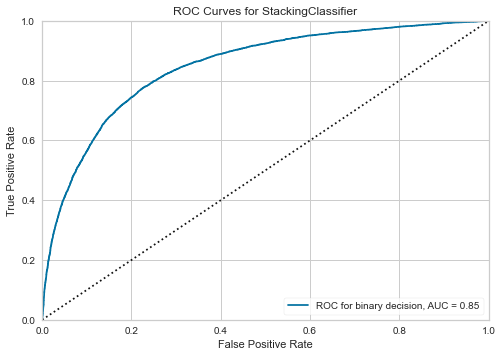

In [31]:
stack_predict = stacking.predict(X_test)
print("accuracy:", metrics.accuracy_score(y_test, stack_predict))
print(metrics.classification_report(y_test, stack_predict))
print(metrics.confusion_matrix(y_test, stack_predict))
visualizer = yb.ROCAUC(stacking, binary=True, classes=[0, 1], is_fitted=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [32]:
%%time
stacking.fit(X, y)

Wall time: 6min 14s


StackingClassifier(estimators=[('tree',
                                HalvingGridSearchCV(estimator=DecisionTreeClassifier(),
                                                    n_jobs=-1,
                                                    param_grid={'max_depth': [3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10,
                                                                              15,
                                                                              

In [33]:
stack_predict = stacking.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

submission['Survived'] = stack_predict
submission.to_csv('../data/submission_stack1.csv', index=False)